# rocketman lab

In [1]:
import sys
sys.path.insert(0, 'C:\\Data\\Dev\\PyCharmProjects\\rocketman\\src')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
import cv2
from peakdetect import peakdetect
import imagehash
from imagecluster import calc as ic
from imagecluster import postproc as pp

import sklearn as sk
from sklearn import cluster as cluster_models
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

Using TensorFlow backend.


# load an preprocess image

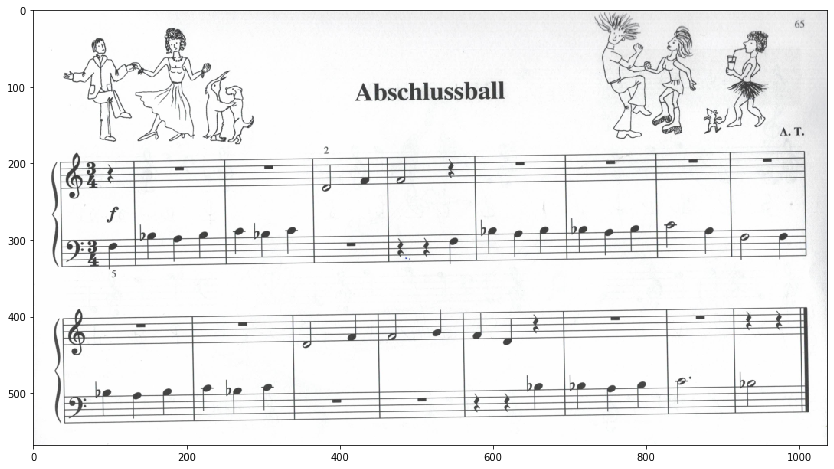

In [3]:
fname = "22"
ftype = ".png"
fpath = "C:\\Data\\Dev-Data\\music\\pieces\\"
fpath_lines = "C:\\Data\\Dev-Data\\music\\lines\\"
fpath_notes = "C:\\Data\\Dev-Data\\music\\notes\\"
filename = fpath + fname + ftype

def plotit (img):
    plt.figure(figsize = (15,8))
    plt.imshow(img,cmap = 'gray')
    plt.show()

image = plt.imread(filename)
plotit (image)

## image manipulation with openCV
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html#gradients

(568, 1037, 4)
(500, 912, 4)


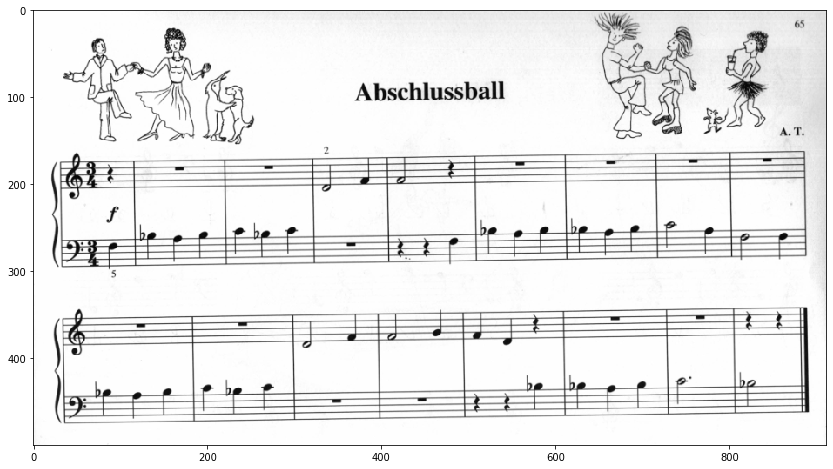

In [4]:
target_height = 500
brightening_factor = 1

# resize
print (image.shape)
height, width, rgb = image.shape
sizing_factor = height / target_height
image = cv2.resize(image,(int(width/sizing_factor),target_height))
print (image.shape)

# gray scale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#brighten
#matrix = np.ones(image.shape, dtype = "uint8") * brightening_factor  
#image = cv2.add(image, matrix, dtype = cv2.CV_8UC1)

# black & white
#val, image = cv2.threshold(image, 50, 255, cv2.THRESH_OTSU)

plotit (image)

## prepare image-vector in Y/X-coords for DBScan

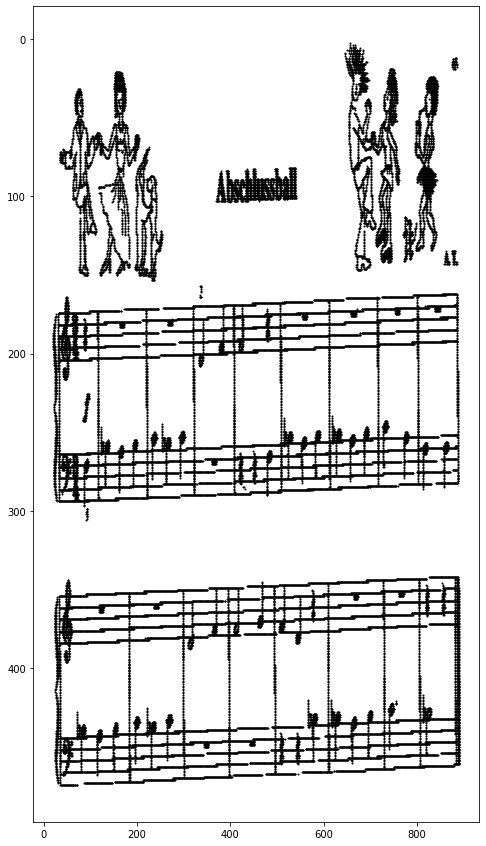

In [5]:
# png
threshold = 0.7

# color image
#height, width, rgb = image.shape

# black/white image
height, width = image.shape

image_scatter = list()
for y in range (height):
    for x in range (width):    
        
        gray = image[y,x]
        if gray < threshold:
            image_scatter.append ([x,y])

image_scatter_array = np.array (image_scatter)

plt.figure(figsize = (8,15))
ax = plt.gca()
ax.invert_yaxis()
plt.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c="black")

## clustering w/ DBScan

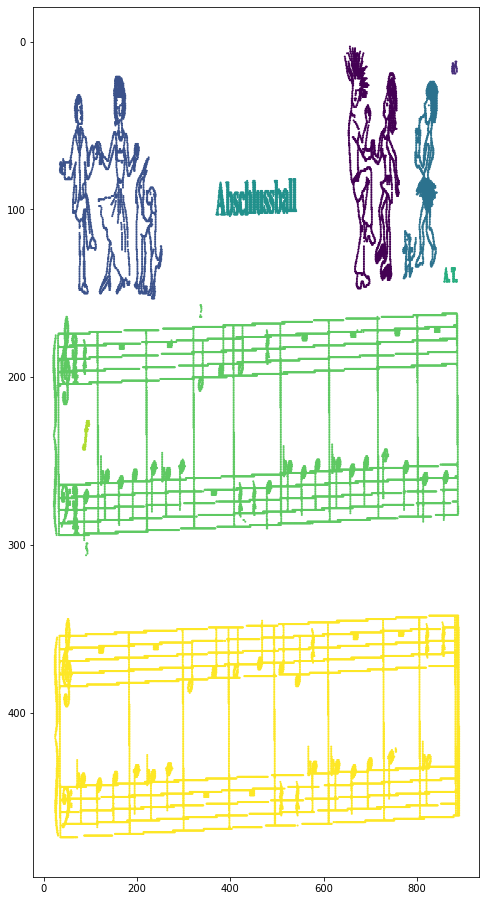

In [6]:
eps = 10

model = cluster_models.DBSCAN(eps=eps)
clusters = model.fit_predict (image_scatter_array)

plt.figure(figsize = (8,16))
ax = plt.gca()
ax.invert_yaxis()
plt.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c=clusters)

## display cluster

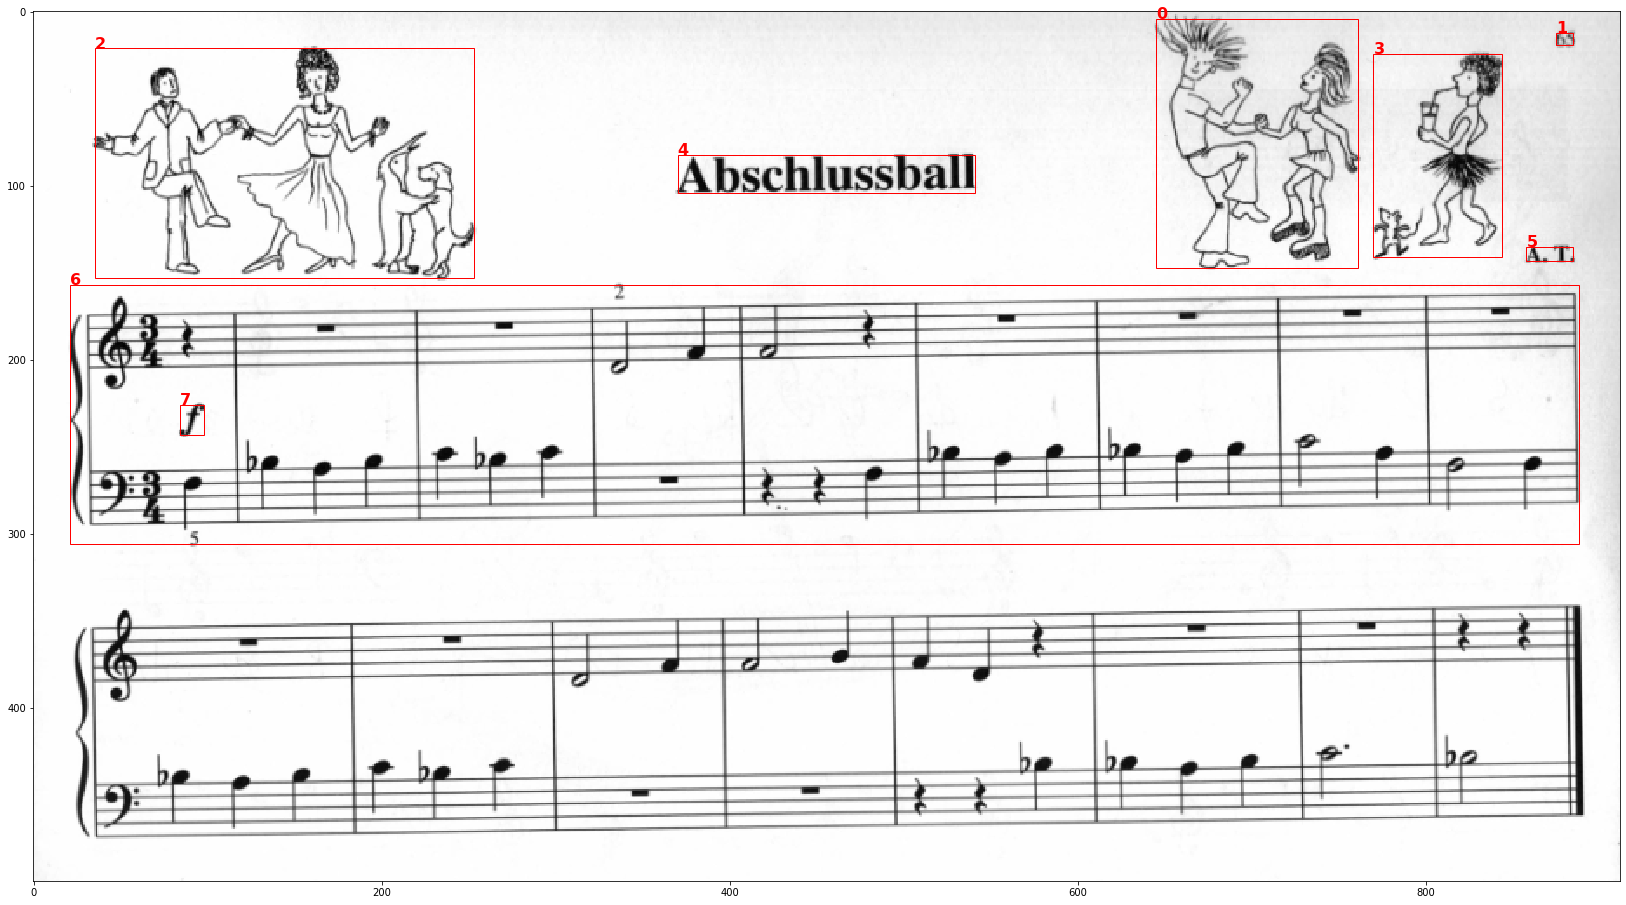

9 CLUSTER


In [7]:
# ALTERNATIVE 1: AUF DEM ORIGINALS
fig,ax = plt.subplots(1,figsize = (30,16))
ax.imshow(image, cmap="gray")

# ALTERNATIVE 2: AUF DEM SCATTERPLOT
#fig,ax = plt.subplots(1,figsize = (8,16))
#ax = plt.gca()
#ax.invert_yaxis()
#ax.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c=clusters)

# RECHTECKE PRO CLUSTER BERECHNEN UND ZEICHNEN
# STEP 0: die Rechtecke für die Cluster werden später für die Vereinigung von Cluster benötigt
class Rectangle:
    def __init__(self, min_x, min_y, max_x, max_y, identificator):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y
        self.identificator = identificator

    def __repr__(self):
        return str(self.identificator) + ": " + str(self.min_x) + "/" + str(self.min_y) + "/" + str(self.max_x) + "/" + str(self.max_y)
        
    def intersects(self, other):
        return not (self.max_x < other.min_x or 
                    self.max_y < other.min_y or 
                    self.min_x > other.max_x or 
                    self.min_y > other.max_y)
    
    def vintersects(self, other):
        return      (self.max_x > other.min_x and other.max_x > self.min_x)
rects = list()
    
# STEP 1: für jedes identifizierte cluster alle Positionen in ein eigenes array übertragen
y = np.array (clusters)
num_cluster = y.max()

cluster_image_array = list()
for i in range (num_cluster):
    c = np.array([image_scatter_array[x] for x in range (1,y.shape[0]) if y[x]==i])
    
    # Sonderbehandlung für Aussreisser
    min_x = c[:,1].min()
    max_x = c[:,1].max()
    min_y = c[:,0].min()
    max_y = c[:,0].max()    
    if not (max_x-min_x) > (height - 50):
        cluster_image_array.append (c)
    
# STEP 2: aus dem array für das Cluster die min und max Werte der X und Y-Position ermitteln
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]

    min_x = cluster_image[:,1].min()
    min_y = cluster_image[:,0].min()
    max_x = cluster_image[:,1].max()
    max_y = cluster_image[:,0].max()

    r = Rectangle(min_x, min_y, max_x, max_y, i)
    rects.append (r)
    
    rect = patches.Rectangle((min_y,min_x),(max_y-min_y), (max_x-min_x),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch (rect)
    ax.text (min_y, min_x, str(i), fontdict={'weight':'bold', 'size':16}, color="red")

plt.show()
print (str(len (cluster_image_array)+1) + " CLUSTER")

## combine overlapping cluster

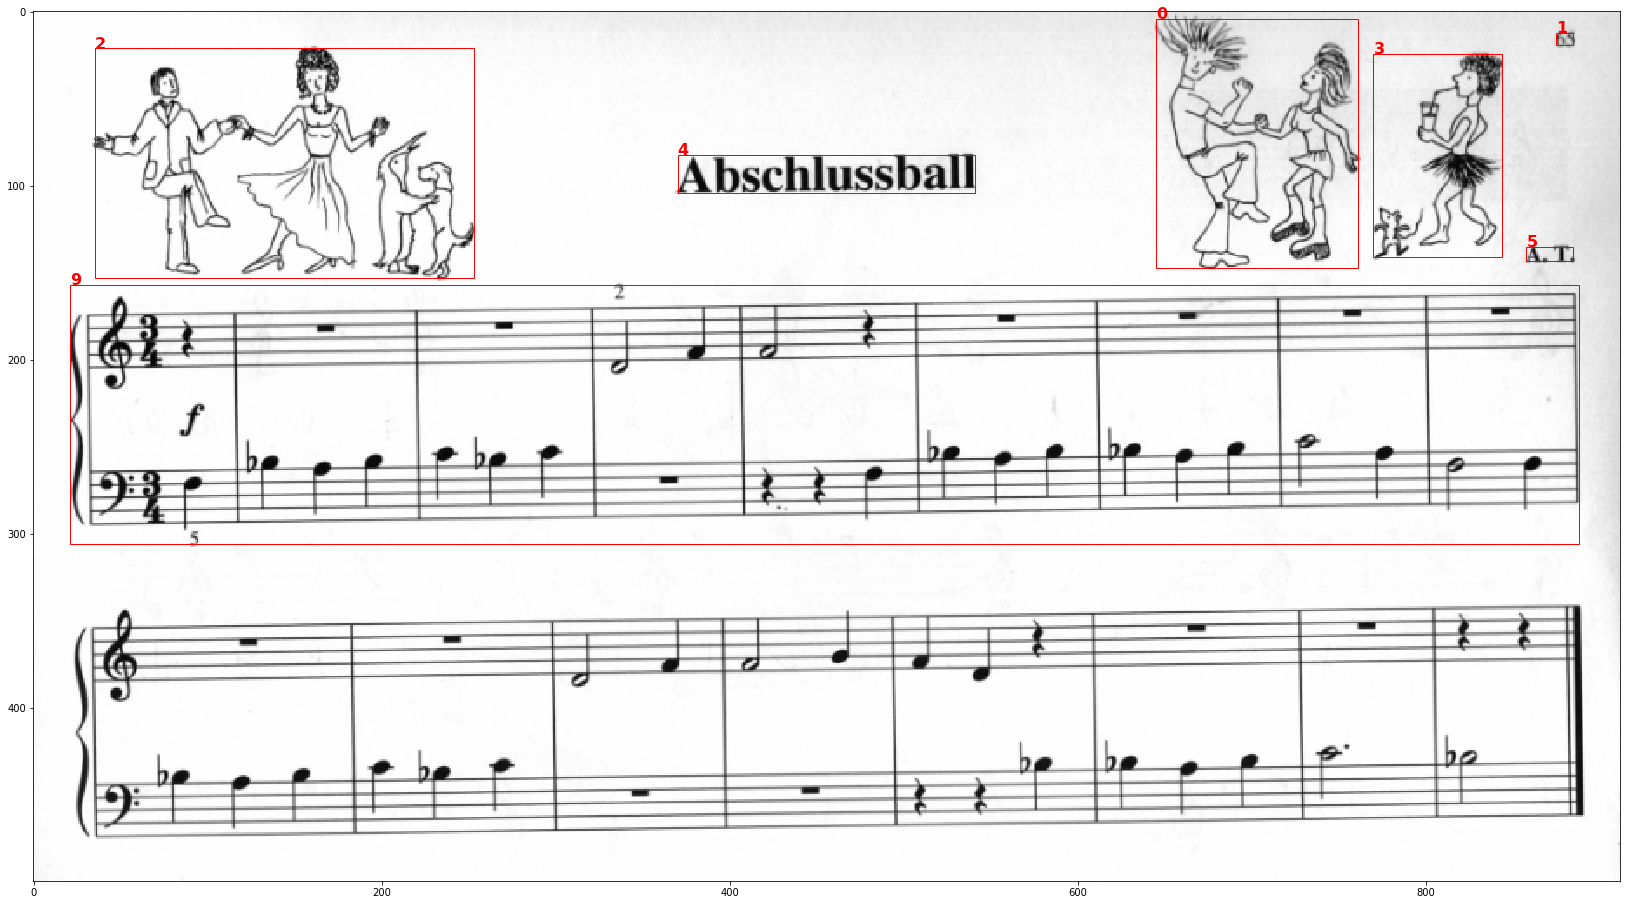

In [8]:
cnt = 0 
num_rects = len (rects)
while cnt<len(rects):
    rect = rects[cnt]
    # print (str(cnt)+": "+str(rect.identificator))
    for cnt2 in range(cnt + 1, len(rects)):
        rect2 = rects[cnt2]
        if rect.intersects (rect2):
            num_rects = num_rects + 1
            #print ("cluster ", rect.identificator, " collides with ", rect2.identificator)
            #print ("-- add: ", num_rects)
            #print ("-- remove", rect.identificator)
            #print ("-- remove", rect2.identificator)

            ci1 = cluster_image_array[cnt]
            ci2 = cluster_image_array[cnt2]
            ci = np.concatenate ((ci1, ci2))
            cluster_image_array.append (ci)
            
            min_y = ci[:,0].min()
            max_y = ci[:,0].max()
            min_x = ci[:,1].min()
            max_x = ci[:,1].max()
            r = Rectangle(min_x, min_y, max_x, max_y, num_rects)
            rects.append (r)
            
            del (cluster_image_array[cnt])
            del (cluster_image_array[cnt2-1])

            del (rects[cnt])
            del (rects[cnt2-1])

            cnt = -1
            break
    cnt = cnt + 1

# neue Zeichnung
fig,ax = plt.subplots(1,figsize = (30,16))
ax.imshow(image, cmap="gray")
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]
    min_y = cluster_image[:,0].min()
    max_y = cluster_image[:,0].max()
    min_x = cluster_image[:,1].min()
    max_x = cluster_image[:,1].max()
    rect = patches.Rectangle((min_y,min_x),(max_y-min_y), (max_x-min_x),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch (rect)
    ax.text (min_y, min_x, str(rects[i].identificator), fontdict={'weight':'bold', 'size':16}, color="red")
plt.show()

## capture single line

0


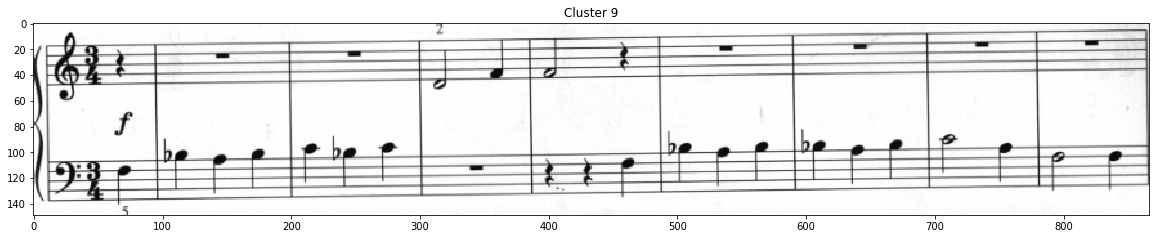

1  images identitfied


In [9]:
min_height = 30
min_width  = 300

selected_images = []

cnt = 0
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]
    min_y= cluster_image[:,0].min()
    max_y= cluster_image[:,0].max()
    min_x= cluster_image[:,1].min()
    max_x= cluster_image[:,1].max()
    if max_y > min_y + min_width and max_x > min_x + min_height and max_y- min_y> max_x- min_x:
        print (cnt)
        selected_images.append (image[min_x:max_x,min_y:max_y])
        plt.figure(figsize = (20,10))
        plt.imshow(image[min_x:max_x,min_y:max_y], cmap="gray")
        plt.title ("Cluster {}".format(rects[i].identificator))
        plt.savefig (fpath_lines+fname+"_"+str(cnt)+ftype)
        plt.show()
        cnt = cnt + 1 

print (len(selected_images)," images identitfied")

## capture single note

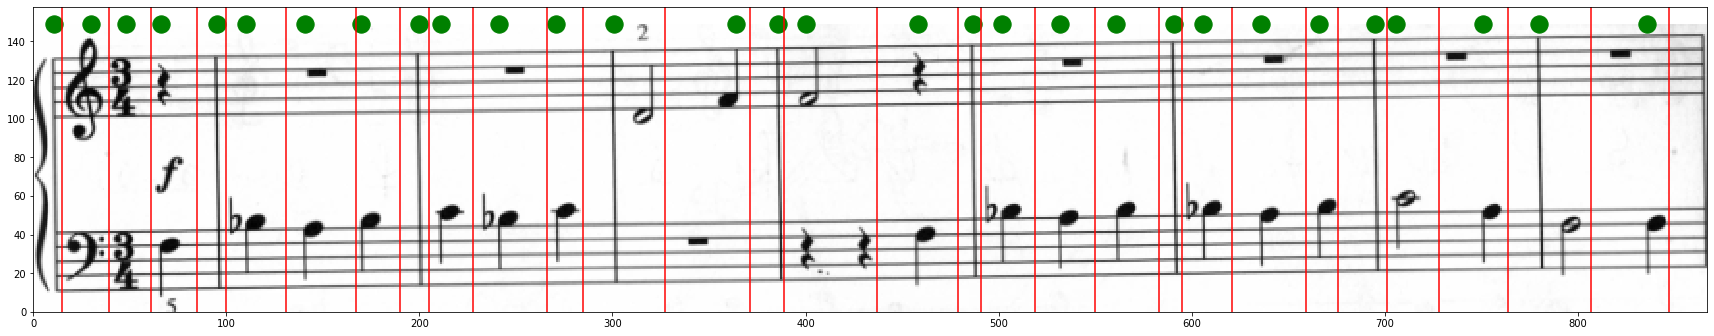

In [10]:
crop_images = []
crop_images_non_prep = []

for cnt in range (0,len (selected_images)):
    
    img = selected_images[cnt]
    img_height = img.shape[0]
    img_width = img.shape[1]

    # calcuate density
    x = 0
    density_array = []
    while x < img_width:
        density = sum (255-img[:,x])
        density_array.append (density)
        x = x + 1
        
    # rescale density to value 0 - 1
    max_val = max (density_array)
    density_array = (density_array / max_val) 

    # detect lows
    peaks = peakdetect(density_array, lookahead=15)

    lows = np.asarray (peaks[1])
    xl = lows[:,0]
    yl = lows[:,1]

    highs = np.asarray(peaks[0])
    xh = highs[:,0]
    yh = highs[:,1]

    fig, ax = plt.subplots(1,figsize = (30,16))
    ax.imshow(img, cmap='gray', extent=[0, img_width, 0, img_height])
    ax.scatter (xh,yh*img_height,s=300,c="green")
    for low in lows:
        ax.axvline (low[0],0,img_height,color="red")
    plt.show ()
    
    # crop single notes
    i = 0
    x1 = 0
    for low in lows:
        x2 = int(low [0])
        crop_img = img[0:img_height, x1:x2]*255
        crop_images_non_prep.append (img[0:img_height, x1:x2]*255)
        
        # having the same image shape will improve performance
        smaller_than_50 = 50-(x2-x1)
        if (smaller_than_50) > 0:
            empty_array = np.full ((img_height,smaller_than_50), 255)
            crop_img = np.concatenate((crop_img, empty_array), axis=1)
        crop_images.append (crop_img)

        # convert to black and white
        crop_img = crop_img.astype(np.uint8)
        retval, crop_img = cv2.threshold(crop_img, 50, 255, cv2.THRESH_OTSU)

        # save image to disk
        tmp = Image.fromarray(crop_img.astype(np.uint32))
        tmp.convert("L").save(fpath_notes+fname+"_"+str(cnt)+"_"+str(i)+ftype)        
        
        x1 = x2
        i = i + 1  
        
    # print crops
    #fig, axs = plt.subplots(1, 30, figsize=(30,5))
    #for j in range (min(30,len(lows))):
    #    axs[j].imshow(crop_images[len(crop_images)-i+j],aspect='auto',cmap='gray')      
    #plt.show()
    
    

In [13]:
# play sound when done
from IPython.display import Audio, display
display(Audio('../sounds/bowl.wav', autoplay=True))


# test:reshaping for in-memory prediction
Hinweis: Wenn die Bilder von Platte geladen werden, kümmert sich die Bibliothek um das Problem.
In-memory müssen wir das 2-Dimensionale Schwarz-Weiss Bild selber in ein RGB Bild (mit den RGB-Werten als 3. Dimension umwandeln)

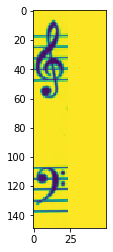

In [14]:
img = crop_images[1]

plt.imshow (img)

In [15]:
img.shape

(149, 50)

In [16]:
import PIL.Image

In [17]:
img = Image.fromarray (img)

In [18]:
# das Bild wird auf die Zielgröße resized + 3-fach vergrössert, damit es später in ein RGB ungewandelt werden kann
img = img.resize ((50*3,255), Image.ANTIALIAS)

In [19]:
img = np.array(img)

In [20]:
img.shape

(255, 150)

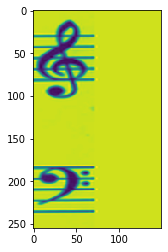

In [21]:
plt.imshow (img)

In [22]:
# umwandeln in ein RGB indem eine dritte Dimension für die RGB Werte hinzugefügt wird
# np.resize füllt fehlende Werte auf
# damit das gleich Bild rauskommt, wurde vorher 3-fach vergrössert (auf der richtigen Achse)
img = np.resize (img, (255, 50, 3))

In [23]:
img.shape

(255, 50, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


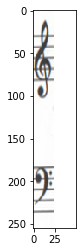

In [24]:
img = img / 255
plt.imshow (img)

In [25]:
img

array([[[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0